# MNIST - Deep convolutional GAN

* Written for the Manning Live Project - "[Semi supervised deep learning with gans for melanoma detection](https://liveproject.manning.com/module/146_7_1/semi-supervised-deep-learning-with-gans-for-melanoma-detection/6--training-the-semi-supervised-gan-for-melanoma-image-classification/6-1-training-the-semi-supervised-gan-for-melanoma-image-classification)"
* Deep convolutional GAN to generate MNIST handwritten digits
* Based on [GANs in Action - Chapter 4](https://livebook.manning.com/book/gans-in-action), [PyTorch DCGan Tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) and [How to Identify and Diagnose GAN failure modes](https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils import data
from torchvision import datasets, transforms

data_set_path = '../Datasets'

z_dims = 100
image_size = 28 * 28


def set_seeds():
    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(12321)

    
def weights_init(model):
    # Specific initialisation of weights needed for Conv, Conv transpose
    # and BatchNorm layers
    class_name = model.__class__.__name__
    if class_name.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif class_name.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

## Dataloading code

In [2]:
def data_loader(batch_size):
    # transform = transforms.ToTensor()
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,))])
    train_set = datasets.MNIST(data_set_path, download=False, train=True, transform=transform)
    test_set = datasets.MNIST(data_set_path, download=False, train=False, transform=transform)

    train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


def batch_random_noise(batch_size):
    return torch.randn(batch_size, z_dims)

## The "generator"

In [3]:
def create_generator_model():
    class Generator(nn.Module):
        def __init__(self):
            super(Generator, self).__init__()
            # z_dims
            self.fc1 = nn.Linear(z_dims, 256 * (7 * 7))
            # 256 x (7 x 7)
            self.cvt1 = nn.ConvTranspose2d(256, 128, (3, 3), stride=2, padding=1, output_padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(128)
            self.leakyReLU1 = nn.ReLU()
            # 128 x (14 x 14)
            self.cvt2 = nn.ConvTranspose2d(128, 64, (3, 3), stride=1, padding=1, bias=False)
            self.bn2 = nn.BatchNorm2d(64)
            self.leakyReLU2 = nn.ReLU()
            # 64 x (14 x 14)
            self.cvt3 = nn.ConvTranspose2d(64, 1, (3, 3), stride=2, padding=1, output_padding=1, bias=False)
            # 1 x (28 x 28)

        def forward(self, x):
            x = self.fc1(x)
            x = x.view(x.size(0), 256, 7, 7)
            x = self.cvt1(x)
            x = self.bn1(x)
            x = self.leakyReLU1(x)
            x = self.cvt2(x)
            x = self.bn2(x)
            x = self.leakyReLU2(x)
            x = self.cvt3(x)
            x = torch.tanh(x)

            return x

    return Generator()

## The "discriminator"

In [4]:
def create_old_discriminator_model():
    # 1 means a fake
    # 0 means real
    class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            # 1 x (28 x 28)
            self.cnv1 = nn.Conv2d(1, 32, (3, 3), stride=2, padding=1)
            self.leakyReLU1 = nn.LeakyReLU(0.2)
            # 32 x (14 x 14)
            self.cnv2 = nn.Conv2d(32, 64, (3, 3), stride=2, padding=1)
            self.bn2 = nn.BatchNorm2d(64)
            self.leakyReLU2 = nn.LeakyReLU(0.2)
            # 64 x (7 x 7)
            self.cnv3 = nn.Conv2d(64, 128, (3, 3), stride=2, padding=0)
            self.bn3 = nn.BatchNorm2d(128)
            self.leakyReLU3 = nn.LeakyReLU(0.2)
            # 128 x (3 x 3)
            self.fc1 = nn.Linear(128 * 3 * 3, 1)


        def forward(self, x):
            x = self.cnv1(x)
            x = self.leakyReLU1(x)

            x = self.cnv2(x)
            x = self.bn2(x)
            x = self.leakyReLU2(x)

            x = self.cnv3(x)
            x = self.bn3(x)
            x = self.leakyReLU3(x)

            x = torch.flatten(x, 1, -1)
            x = self.fc1(x)
            x = torch.sigmoid(x)

            return x

    return Discriminator()

## Test code

In [5]:
def accuracy(output, wanted):
    with torch.no_grad():
        predicted = output.numpy() > 0.5
        total = output.size(0)
        correct = (predicted == wanted.numpy()).sum().item()
        return correct / total

## Image renderer

In [6]:
def view_images(epoch, index, generator, discriminator, sample):
    generator.eval()
    discriminator.eval()

    with torch.no_grad():
        # obtain one batch of test images
        gen_image = generator(sample)
        classification = discriminator(gen_image)
        gen_image = gen_image.view(sample.size(0), 1, 28, 28)
        gen_image = 0.5 * gen_image + 0.5
        classification = classification.squeeze()

        # plot the first ten input images, then reconstructed images, then generated images
        fig, axes = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True)

        fig.suptitle('Epoch: ' + str(epoch)+ ' Index:' + str(index))

        for img, label, ax in zip(gen_image, classification, axes):
            img = img.detach().numpy()
            ax.set_title('Fake' if label > 0.5 else 'Real')
            ax.imshow(np.squeeze(img), cmap='gray_r')

            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

## Training loop

In [12]:
def train(sample, epochs, train_loader, generator_optimizer, discriminator_optimizer,
          generator, discriminator, criterion):
#     batches_per_epoch = 50

    discriminator.train()
    generator.train()

    # Don't use eval for discriminator when training the generator - and Batch Normalisation
    # It is a complete disaster.
    # Instead keep the discriminator in training mode
    for epoch in range(epochs):
        print("\nEpoch: ", epoch)
        for index, (images, labels) in enumerate(train_loader):
#         data_iter = iter(train_loader)
#         for index in range(batches_per_epoch):
#             images, labels = data_iter.next()

            batch_size = labels.size(0)
            # real_ones = torch.zeros(batch_size)
            # fakes = torch.ones(batch_size)

            # Train discriminator - real batch
            # Discriminator must mark the real images 0 and the fake images 1
            discriminator_optimizer.zero_grad()
            output_real = discriminator(images)
            loss_real = criterion(output_real.squeeze(), torch.zeros(batch_size))
            d_real_accuracy = accuracy(output_real.squeeze(), torch.zeros(batch_size))
            loss_real.backward()

            # Train discriminator - fake batch
            random_noise1 = batch_random_noise(batch_size)
            fake_images1 = generator(random_noise1)
            output_fake1 = discriminator(fake_images1.detach())
            loss_fake = criterion(output_fake1.squeeze(), torch.ones(batch_size))
            d_loss_accuracy = accuracy(output_fake1.squeeze(), torch.ones(batch_size))
            loss_fake.backward()
            discriminator_optimizer.step()

            # Train generator
            generator_optimizer.zero_grad()

            # random_noise2 = batch_random_noise(batch_size)
            # fake_images2 = generator(random_noise2)
            output_fake2 = discriminator(fake_images1)

            # Generator must cause the discriminator to mark the fake images as real
            # ie to fool the discriminator
            generator_loss = criterion(output_fake2.squeeze(), torch.zeros(batch_size))
            gen_accuracy = accuracy(output_fake2.squeeze(), torch.zeros(batch_size))

            generator_loss.backward()
            generator_optimizer.step()

            generator_total_loss = generator_loss.item()
            discriminator_loss_real = loss_real.item()
            discriminator_loss_fake = loss_fake.item()

            print('Epoch: %d, Iteration: %i, Gen Loss: %.3f, Gen Accuracy: %.3f, '
                  'DReal loss: %.3f, DReal accuracy: %.3f, '
                  'DFake loss: %.3f, DFake accuracy: %.3f' %
                  (epoch, index, generator_total_loss, gen_accuracy,
                   discriminator_loss_real, d_real_accuracy,
                   discriminator_loss_fake, d_loss_accuracy))

            if (index % 50) == 0:
                view_images(epoch, index, generator, discriminator, sample)

## Train GAN

* Trains GAN
* Outputs training status - loss and accuracy - every batch
* Every 50 batches outputs the current images. The same random sample is used for each image output so the improvement in the model can be seen visually


Epoch:  0
Epoch: 0, Iteration: 0, Gen Loss: 1.093, Gen Accuracy: 0.000, DReal loss: 0.861, DReal accuracy: 0.078, DFake loss: 0.520, DFake accuracy: 0.984
Epoch: 0, Iteration: 1, Gen Loss: 0.701, Gen Accuracy: 0.000, DReal loss: 0.701, DReal accuracy: 0.000, DFake loss: 0.685, DFake accuracy: 1.000
Epoch: 0, Iteration: 2, Gen Loss: 0.700, Gen Accuracy: 0.000, DReal loss: 0.700, DReal accuracy: 0.000, DFake loss: 0.685, DFake accuracy: 1.000
Epoch: 0, Iteration: 3, Gen Loss: 0.700, Gen Accuracy: 0.000, DReal loss: 0.699, DReal accuracy: 0.000, DFake loss: 0.686, DFake accuracy: 1.000
Epoch: 0, Iteration: 4, Gen Loss: 0.700, Gen Accuracy: 0.000, DReal loss: 0.698, DReal accuracy: 0.000, DFake loss: 0.686, DFake accuracy: 1.000
Epoch: 0, Iteration: 5, Gen Loss: 0.699, Gen Accuracy: 0.000, DReal loss: 0.697, DReal accuracy: 0.000, DFake loss: 0.687, DFake accuracy: 1.000
Epoch: 0, Iteration: 6, Gen Loss: 0.699, Gen Accuracy: 0.000, DReal loss: 0.697, DReal accuracy: 0.000, DFake loss: 0.6

Epoch: 0, Iteration: 57, Gen Loss: 0.843, Gen Accuracy: 0.000, DReal loss: 0.606, DReal accuracy: 0.977, DFake loss: 0.587, DFake accuracy: 1.000
Epoch: 0, Iteration: 58, Gen Loss: 0.844, Gen Accuracy: 0.000, DReal loss: 0.608, DReal accuracy: 0.969, DFake loss: 0.588, DFake accuracy: 1.000
Epoch: 0, Iteration: 59, Gen Loss: 0.847, Gen Accuracy: 0.000, DReal loss: 0.601, DReal accuracy: 0.961, DFake loss: 0.591, DFake accuracy: 1.000
Epoch: 0, Iteration: 60, Gen Loss: 0.848, Gen Accuracy: 0.000, DReal loss: 0.600, DReal accuracy: 0.969, DFake loss: 0.595, DFake accuracy: 1.000
Epoch: 0, Iteration: 61, Gen Loss: 0.837, Gen Accuracy: 0.000, DReal loss: 0.610, DReal accuracy: 0.914, DFake loss: 0.592, DFake accuracy: 1.000
Epoch: 0, Iteration: 62, Gen Loss: 0.832, Gen Accuracy: 0.000, DReal loss: 0.618, DReal accuracy: 0.891, DFake loss: 0.606, DFake accuracy: 1.000
Epoch: 0, Iteration: 63, Gen Loss: 0.823, Gen Accuracy: 0.000, DReal loss: 0.632, DReal accuracy: 0.875, DFake loss: 0.609, 

Epoch: 0, Iteration: 114, Gen Loss: 2.912, Gen Accuracy: 0.000, DReal loss: 0.080, DReal accuracy: 1.000, DFake loss: 0.071, DFake accuracy: 1.000
Epoch: 0, Iteration: 115, Gen Loss: 2.774, Gen Accuracy: 0.000, DReal loss: 0.115, DReal accuracy: 0.984, DFake loss: 0.063, DFake accuracy: 1.000
Epoch: 0, Iteration: 116, Gen Loss: 3.036, Gen Accuracy: 0.000, DReal loss: 0.054, DReal accuracy: 1.000, DFake loss: 0.079, DFake accuracy: 1.000
Epoch: 0, Iteration: 117, Gen Loss: 2.979, Gen Accuracy: 0.008, DReal loss: 0.108, DReal accuracy: 0.984, DFake loss: 0.085, DFake accuracy: 0.992
Epoch: 0, Iteration: 118, Gen Loss: 3.221, Gen Accuracy: 0.031, DReal loss: 0.098, DReal accuracy: 0.977, DFake loss: 0.146, DFake accuracy: 0.961
Epoch: 0, Iteration: 119, Gen Loss: 3.408, Gen Accuracy: 0.023, DReal loss: 0.114, DReal accuracy: 1.000, DFake loss: 0.118, DFake accuracy: 0.969
Epoch: 0, Iteration: 120, Gen Loss: 3.423, Gen Accuracy: 0.102, DReal loss: 0.151, DReal accuracy: 0.961, DFake loss: 

Epoch: 0, Iteration: 170, Gen Loss: 0.856, Gen Accuracy: 0.031, DReal loss: 0.625, DReal accuracy: 0.656, DFake loss: 0.762, DFake accuracy: 0.211
Epoch: 0, Iteration: 171, Gen Loss: 0.711, Gen Accuracy: 0.500, DReal loss: 0.759, DReal accuracy: 0.422, DFake loss: 0.576, DFake accuracy: 0.906
Epoch: 0, Iteration: 172, Gen Loss: 0.825, Gen Accuracy: 0.086, DReal loss: 0.638, DReal accuracy: 0.727, DFake loss: 0.716, DFake accuracy: 0.453
Epoch: 0, Iteration: 173, Gen Loss: 0.752, Gen Accuracy: 0.320, DReal loss: 0.717, DReal accuracy: 0.500, DFake loss: 0.602, DFake accuracy: 0.828
Epoch: 0, Iteration: 174, Gen Loss: 0.834, Gen Accuracy: 0.055, DReal loss: 0.617, DReal accuracy: 0.766, DFake loss: 0.673, DFake accuracy: 0.625
Epoch: 0, Iteration: 175, Gen Loss: 0.701, Gen Accuracy: 0.500, DReal loss: 0.727, DReal accuracy: 0.516, DFake loss: 0.594, DFake accuracy: 0.906
Epoch: 0, Iteration: 176, Gen Loss: 0.956, Gen Accuracy: 0.000, DReal loss: 0.564, DReal accuracy: 0.852, DFake loss: 

Epoch: 0, Iteration: 226, Gen Loss: 0.760, Gen Accuracy: 0.453, DReal loss: 0.737, DReal accuracy: 0.492, DFake loss: 0.580, DFake accuracy: 0.664
Epoch: 0, Iteration: 227, Gen Loss: 0.845, Gen Accuracy: 0.406, DReal loss: 0.585, DReal accuracy: 0.695, DFake loss: 0.718, DFake accuracy: 0.484
Epoch: 0, Iteration: 228, Gen Loss: 0.833, Gen Accuracy: 0.367, DReal loss: 0.678, DReal accuracy: 0.539, DFake loss: 0.591, DFake accuracy: 0.695
Epoch: 0, Iteration: 229, Gen Loss: 0.868, Gen Accuracy: 0.422, DReal loss: 0.609, DReal accuracy: 0.648, DFake loss: 0.660, DFake accuracy: 0.555
Epoch: 0, Iteration: 230, Gen Loss: 0.892, Gen Accuracy: 0.352, DReal loss: 0.614, DReal accuracy: 0.633, DFake loss: 0.637, DFake accuracy: 0.594
Epoch: 0, Iteration: 231, Gen Loss: 0.871, Gen Accuracy: 0.406, DReal loss: 0.641, DReal accuracy: 0.578, DFake loss: 0.595, DFake accuracy: 0.633
Epoch: 0, Iteration: 232, Gen Loss: 0.864, Gen Accuracy: 0.391, DReal loss: 0.608, DReal accuracy: 0.664, DFake loss: 

Epoch: 0, Iteration: 282, Gen Loss: 0.773, Gen Accuracy: 0.367, DReal loss: 0.645, DReal accuracy: 0.680, DFake loss: 0.590, DFake accuracy: 0.711
Epoch: 0, Iteration: 283, Gen Loss: 0.967, Gen Accuracy: 0.117, DReal loss: 0.539, DReal accuracy: 0.797, DFake loss: 0.696, DFake accuracy: 0.555
Epoch: 0, Iteration: 284, Gen Loss: 0.757, Gen Accuracy: 0.398, DReal loss: 0.725, DReal accuracy: 0.469, DFake loss: 0.536, DFake accuracy: 0.852
Epoch: 0, Iteration: 285, Gen Loss: 0.873, Gen Accuracy: 0.242, DReal loss: 0.558, DReal accuracy: 0.812, DFake loss: 0.703, DFake accuracy: 0.500
Epoch: 0, Iteration: 286, Gen Loss: 0.774, Gen Accuracy: 0.375, DReal loss: 0.696, DReal accuracy: 0.578, DFake loss: 0.552, DFake accuracy: 0.844
Epoch: 0, Iteration: 287, Gen Loss: 0.886, Gen Accuracy: 0.211, DReal loss: 0.563, DReal accuracy: 0.766, DFake loss: 0.695, DFake accuracy: 0.523
Epoch: 0, Iteration: 288, Gen Loss: 0.780, Gen Accuracy: 0.359, DReal loss: 0.697, DReal accuracy: 0.570, DFake loss: 

Epoch: 0, Iteration: 338, Gen Loss: 0.796, Gen Accuracy: 0.258, DReal loss: 0.635, DReal accuracy: 0.719, DFake loss: 0.722, DFake accuracy: 0.500
Epoch: 0, Iteration: 339, Gen Loss: 0.705, Gen Accuracy: 0.414, DReal loss: 0.726, DReal accuracy: 0.438, DFake loss: 0.623, DFake accuracy: 0.734
Epoch: 0, Iteration: 340, Gen Loss: 0.738, Gen Accuracy: 0.320, DReal loss: 0.644, DReal accuracy: 0.695, DFake loss: 0.689, DFake accuracy: 0.625
Epoch: 0, Iteration: 341, Gen Loss: 0.789, Gen Accuracy: 0.234, DReal loss: 0.638, DReal accuracy: 0.703, DFake loss: 0.684, DFake accuracy: 0.625
Epoch: 0, Iteration: 342, Gen Loss: 0.738, Gen Accuracy: 0.328, DReal loss: 0.691, DReal accuracy: 0.531, DFake loss: 0.643, DFake accuracy: 0.727
Epoch: 0, Iteration: 343, Gen Loss: 0.745, Gen Accuracy: 0.414, DReal loss: 0.657, DReal accuracy: 0.641, DFake loss: 0.685, DFake accuracy: 0.547
Epoch: 0, Iteration: 344, Gen Loss: 0.705, Gen Accuracy: 0.445, DReal loss: 0.688, DReal accuracy: 0.508, DFake loss: 

Epoch: 0, Iteration: 394, Gen Loss: 0.755, Gen Accuracy: 0.336, DReal loss: 0.676, DReal accuracy: 0.633, DFake loss: 0.705, DFake accuracy: 0.516
Epoch: 0, Iteration: 395, Gen Loss: 0.699, Gen Accuracy: 0.539, DReal loss: 0.716, DReal accuracy: 0.562, DFake loss: 0.664, DFake accuracy: 0.609
Epoch: 0, Iteration: 396, Gen Loss: 0.737, Gen Accuracy: 0.359, DReal loss: 0.665, DReal accuracy: 0.703, DFake loss: 0.711, DFake accuracy: 0.469
Epoch: 0, Iteration: 397, Gen Loss: 0.685, Gen Accuracy: 0.555, DReal loss: 0.725, DReal accuracy: 0.570, DFake loss: 0.666, DFake accuracy: 0.602
Epoch: 0, Iteration: 398, Gen Loss: 0.797, Gen Accuracy: 0.164, DReal loss: 0.629, DReal accuracy: 0.781, DFake loss: 0.725, DFake accuracy: 0.383
Epoch: 0, Iteration: 399, Gen Loss: 0.640, Gen Accuracy: 0.688, DReal loss: 0.771, DReal accuracy: 0.344, DFake loss: 0.616, DFake accuracy: 0.781
Epoch: 0, Iteration: 400, Gen Loss: 0.826, Gen Accuracy: 0.125, DReal loss: 0.596, DReal accuracy: 0.812, DFake loss: 

Epoch: 0, Iteration: 450, Gen Loss: 0.969, Gen Accuracy: 0.047, DReal loss: 0.524, DReal accuracy: 0.859, DFake loss: 0.735, DFake accuracy: 0.453
Epoch: 0, Iteration: 451, Gen Loss: 0.621, Gen Accuracy: 0.727, DReal loss: 0.801, DReal accuracy: 0.312, DFake loss: 0.494, DFake accuracy: 0.961
Epoch: 0, Iteration: 452, Gen Loss: 0.999, Gen Accuracy: 0.055, DReal loss: 0.490, DReal accuracy: 0.953, DFake loss: 0.844, DFake accuracy: 0.156
Epoch: 0, Iteration: 453, Gen Loss: 0.618, Gen Accuracy: 0.766, DReal loss: 0.867, DReal accuracy: 0.164, DFake loss: 0.496, DFake accuracy: 0.945
Epoch: 0, Iteration: 454, Gen Loss: 0.890, Gen Accuracy: 0.094, DReal loss: 0.519, DReal accuracy: 0.953, DFake loss: 0.805, DFake accuracy: 0.234
Epoch: 0, Iteration: 455, Gen Loss: 0.745, Gen Accuracy: 0.328, DReal loss: 0.726, DReal accuracy: 0.359, DFake loss: 0.542, DFake accuracy: 0.930
Epoch: 0, Iteration: 456, Gen Loss: 0.781, Gen Accuracy: 0.180, DReal loss: 0.605, DReal accuracy: 0.773, DFake loss: 

Epoch: 1, Iteration: 37, Gen Loss: 0.837, Gen Accuracy: 0.164, DReal loss: 0.591, DReal accuracy: 0.805, DFake loss: 0.769, DFake accuracy: 0.258
Epoch: 1, Iteration: 38, Gen Loss: 0.639, Gen Accuracy: 0.680, DReal loss: 0.777, DReal accuracy: 0.344, DFake loss: 0.570, DFake accuracy: 0.914
Epoch: 1, Iteration: 39, Gen Loss: 0.902, Gen Accuracy: 0.062, DReal loss: 0.558, DReal accuracy: 0.836, DFake loss: 0.777, DFake accuracy: 0.289
Epoch: 1, Iteration: 40, Gen Loss: 0.657, Gen Accuracy: 0.609, DReal loss: 0.776, DReal accuracy: 0.289, DFake loss: 0.542, DFake accuracy: 0.930
Epoch: 1, Iteration: 41, Gen Loss: 0.847, Gen Accuracy: 0.156, DReal loss: 0.567, DReal accuracy: 0.797, DFake loss: 0.732, DFake accuracy: 0.406
Epoch: 1, Iteration: 42, Gen Loss: 0.782, Gen Accuracy: 0.312, DReal loss: 0.683, DReal accuracy: 0.555, DFake loss: 0.604, DFake accuracy: 0.758
Epoch: 1, Iteration: 43, Gen Loss: 0.784, Gen Accuracy: 0.336, DReal loss: 0.649, DReal accuracy: 0.664, DFake loss: 0.690, 

Epoch: 1, Iteration: 94, Gen Loss: 0.740, Gen Accuracy: 0.289, DReal loss: 0.660, DReal accuracy: 0.680, DFake loss: 0.774, DFake accuracy: 0.195
Epoch: 1, Iteration: 95, Gen Loss: 0.697, Gen Accuracy: 0.523, DReal loss: 0.750, DReal accuracy: 0.312, DFake loss: 0.685, DFake accuracy: 0.531
Epoch: 1, Iteration: 96, Gen Loss: 0.655, Gen Accuracy: 0.719, DReal loss: 0.734, DReal accuracy: 0.375, DFake loss: 0.707, DFake accuracy: 0.445
Epoch: 1, Iteration: 97, Gen Loss: 0.710, Gen Accuracy: 0.438, DReal loss: 0.703, DReal accuracy: 0.438, DFake loss: 0.777, DFake accuracy: 0.227
Epoch: 1, Iteration: 98, Gen Loss: 0.679, Gen Accuracy: 0.562, DReal loss: 0.758, DReal accuracy: 0.258, DFake loss: 0.708, DFake accuracy: 0.523
Epoch: 1, Iteration: 99, Gen Loss: 0.711, Gen Accuracy: 0.445, DReal loss: 0.705, DReal accuracy: 0.469, DFake loss: 0.763, DFake accuracy: 0.273
Epoch: 1, Iteration: 100, Gen Loss: 0.645, Gen Accuracy: 0.633, DReal loss: 0.784, DReal accuracy: 0.242, DFake loss: 0.719,

Epoch: 1, Iteration: 150, Gen Loss: 0.810, Gen Accuracy: 0.273, DReal loss: 0.642, DReal accuracy: 0.680, DFake loss: 0.657, DFake accuracy: 0.602
Epoch: 1, Iteration: 151, Gen Loss: 0.779, Gen Accuracy: 0.312, DReal loss: 0.666, DReal accuracy: 0.633, DFake loss: 0.622, DFake accuracy: 0.719
Epoch: 1, Iteration: 152, Gen Loss: 0.812, Gen Accuracy: 0.266, DReal loss: 0.623, DReal accuracy: 0.750, DFake loss: 0.671, DFake accuracy: 0.562
Epoch: 1, Iteration: 153, Gen Loss: 0.852, Gen Accuracy: 0.148, DReal loss: 0.623, DReal accuracy: 0.758, DFake loss: 0.646, DFake accuracy: 0.633
Epoch: 1, Iteration: 154, Gen Loss: 0.728, Gen Accuracy: 0.445, DReal loss: 0.726, DReal accuracy: 0.516, DFake loss: 0.598, DFake accuracy: 0.695
Epoch: 1, Iteration: 155, Gen Loss: 0.843, Gen Accuracy: 0.102, DReal loss: 0.589, DReal accuracy: 0.828, DFake loss: 0.713, DFake accuracy: 0.438
Epoch: 1, Iteration: 156, Gen Loss: 0.794, Gen Accuracy: 0.195, DReal loss: 0.677, DReal accuracy: 0.648, DFake loss: 

Epoch: 1, Iteration: 206, Gen Loss: 0.773, Gen Accuracy: 0.281, DReal loss: 0.665, DReal accuracy: 0.555, DFake loss: 0.638, DFake accuracy: 0.711
Epoch: 1, Iteration: 207, Gen Loss: 0.722, Gen Accuracy: 0.414, DReal loss: 0.683, DReal accuracy: 0.500, DFake loss: 0.649, DFake accuracy: 0.719
Epoch: 1, Iteration: 208, Gen Loss: 0.829, Gen Accuracy: 0.148, DReal loss: 0.606, DReal accuracy: 0.750, DFake loss: 0.719, DFake accuracy: 0.438
Epoch: 1, Iteration: 209, Gen Loss: 0.678, Gen Accuracy: 0.586, DReal loss: 0.755, DReal accuracy: 0.383, DFake loss: 0.599, DFake accuracy: 0.789
Epoch: 1, Iteration: 210, Gen Loss: 0.781, Gen Accuracy: 0.219, DReal loss: 0.603, DReal accuracy: 0.742, DFake loss: 0.730, DFake accuracy: 0.391
Epoch: 1, Iteration: 211, Gen Loss: 0.720, Gen Accuracy: 0.391, DReal loss: 0.713, DReal accuracy: 0.477, DFake loss: 0.654, DFake accuracy: 0.680
Epoch: 1, Iteration: 212, Gen Loss: 0.729, Gen Accuracy: 0.359, DReal loss: 0.666, DReal accuracy: 0.602, DFake loss: 

Epoch: 1, Iteration: 262, Gen Loss: 0.744, Gen Accuracy: 0.312, DReal loss: 0.650, DReal accuracy: 0.656, DFake loss: 0.683, DFake accuracy: 0.594
Epoch: 1, Iteration: 263, Gen Loss: 0.762, Gen Accuracy: 0.258, DReal loss: 0.664, DReal accuracy: 0.625, DFake loss: 0.658, DFake accuracy: 0.648
Epoch: 1, Iteration: 264, Gen Loss: 0.756, Gen Accuracy: 0.312, DReal loss: 0.662, DReal accuracy: 0.586, DFake loss: 0.640, DFake accuracy: 0.727
Epoch: 1, Iteration: 265, Gen Loss: 0.761, Gen Accuracy: 0.312, DReal loss: 0.650, DReal accuracy: 0.695, DFake loss: 0.666, DFake accuracy: 0.633
Epoch: 1, Iteration: 266, Gen Loss: 0.749, Gen Accuracy: 0.422, DReal loss: 0.678, DReal accuracy: 0.602, DFake loss: 0.656, DFake accuracy: 0.602
Epoch: 1, Iteration: 267, Gen Loss: 0.743, Gen Accuracy: 0.391, DReal loss: 0.673, DReal accuracy: 0.633, DFake loss: 0.661, DFake accuracy: 0.609
Epoch: 1, Iteration: 268, Gen Loss: 0.735, Gen Accuracy: 0.344, DReal loss: 0.683, DReal accuracy: 0.594, DFake loss: 

Epoch: 1, Iteration: 318, Gen Loss: 0.691, Gen Accuracy: 0.531, DReal loss: 0.706, DReal accuracy: 0.508, DFake loss: 0.612, DFake accuracy: 0.898
Epoch: 1, Iteration: 319, Gen Loss: 0.826, Gen Accuracy: 0.047, DReal loss: 0.589, DReal accuracy: 0.906, DFake loss: 0.705, DFake accuracy: 0.406
Epoch: 1, Iteration: 320, Gen Loss: 0.694, Gen Accuracy: 0.508, DReal loss: 0.719, DReal accuracy: 0.398, DFake loss: 0.584, DFake accuracy: 0.891
Epoch: 1, Iteration: 321, Gen Loss: 0.778, Gen Accuracy: 0.211, DReal loss: 0.605, DReal accuracy: 0.836, DFake loss: 0.713, DFake accuracy: 0.438
Epoch: 1, Iteration: 322, Gen Loss: 0.752, Gen Accuracy: 0.273, DReal loss: 0.675, DReal accuracy: 0.602, DFake loss: 0.641, DFake accuracy: 0.758
Epoch: 1, Iteration: 323, Gen Loss: 0.733, Gen Accuracy: 0.344, DReal loss: 0.659, DReal accuracy: 0.672, DFake loss: 0.644, DFake accuracy: 0.719
Epoch: 1, Iteration: 324, Gen Loss: 0.781, Gen Accuracy: 0.188, DReal loss: 0.633, DReal accuracy: 0.695, DFake loss: 

Epoch: 1, Iteration: 374, Gen Loss: 0.724, Gen Accuracy: 0.336, DReal loss: 0.672, DReal accuracy: 0.633, DFake loss: 0.703, DFake accuracy: 0.531
Epoch: 1, Iteration: 375, Gen Loss: 0.763, Gen Accuracy: 0.258, DReal loss: 0.664, DReal accuracy: 0.680, DFake loss: 0.678, DFake accuracy: 0.609
Epoch: 1, Iteration: 376, Gen Loss: 0.688, Gen Accuracy: 0.539, DReal loss: 0.715, DReal accuracy: 0.523, DFake loss: 0.652, DFake accuracy: 0.672
Epoch: 1, Iteration: 377, Gen Loss: 0.765, Gen Accuracy: 0.320, DReal loss: 0.654, DReal accuracy: 0.664, DFake loss: 0.718, DFake accuracy: 0.430
Epoch: 1, Iteration: 378, Gen Loss: 0.702, Gen Accuracy: 0.453, DReal loss: 0.719, DReal accuracy: 0.414, DFake loss: 0.647, DFake accuracy: 0.750
Epoch: 1, Iteration: 379, Gen Loss: 0.740, Gen Accuracy: 0.305, DReal loss: 0.662, DReal accuracy: 0.656, DFake loss: 0.699, DFake accuracy: 0.500
Epoch: 1, Iteration: 380, Gen Loss: 0.711, Gen Accuracy: 0.438, DReal loss: 0.695, DReal accuracy: 0.531, DFake loss: 

Epoch: 1, Iteration: 430, Gen Loss: 0.694, Gen Accuracy: 0.547, DReal loss: 0.726, DReal accuracy: 0.398, DFake loss: 0.600, DFake accuracy: 0.852
Epoch: 1, Iteration: 431, Gen Loss: 0.768, Gen Accuracy: 0.195, DReal loss: 0.624, DReal accuracy: 0.773, DFake loss: 0.730, DFake accuracy: 0.359
Epoch: 1, Iteration: 432, Gen Loss: 0.726, Gen Accuracy: 0.328, DReal loss: 0.699, DReal accuracy: 0.539, DFake loss: 0.637, DFake accuracy: 0.773
Epoch: 1, Iteration: 433, Gen Loss: 0.724, Gen Accuracy: 0.391, DReal loss: 0.655, DReal accuracy: 0.648, DFake loss: 0.654, DFake accuracy: 0.672
Epoch: 1, Iteration: 434, Gen Loss: 0.785, Gen Accuracy: 0.172, DReal loss: 0.635, DReal accuracy: 0.773, DFake loss: 0.677, DFake accuracy: 0.617
Epoch: 1, Iteration: 435, Gen Loss: 0.698, Gen Accuracy: 0.516, DReal loss: 0.704, DReal accuracy: 0.539, DFake loss: 0.630, DFake accuracy: 0.773
Epoch: 1, Iteration: 436, Gen Loss: 0.776, Gen Accuracy: 0.172, DReal loss: 0.626, DReal accuracy: 0.797, DFake loss: 

/Users/rachelbowyer/opt/miniconda3/envs/melanoma/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch: 2, Iteration: 1, Gen Loss: 0.966, Gen Accuracy: 0.000, DReal loss: 0.520, DReal accuracy: 0.984, DFake loss: 0.841, DFake accuracy: 0.070
Epoch: 2, Iteration: 2, Gen Loss: 0.565, Gen Accuracy: 0.938, DReal loss: 0.854, DReal accuracy: 0.070, DFake loss: 0.507, DFake accuracy: 0.977
Epoch: 2, Iteration: 3, Gen Loss: 0.927, Gen Accuracy: 0.008, DReal loss: 0.503, DReal accuracy: 1.000, DFake loss: 0.850, DFake accuracy: 0.070
Epoch: 2, Iteration: 4, Gen Loss: 0.628, Gen Accuracy: 0.711, DReal loss: 0.815, DReal accuracy: 0.164, DFake loss: 0.494, DFake accuracy: 0.992
Epoch: 2, Iteration: 5, Gen Loss: 0.875, Gen Accuracy: 0.078, DReal loss: 0.536, DReal accuracy: 0.898, DFake loss: 0.824, DFake accuracy: 0.148
Epoch: 2, Iteration: 6, Gen Loss: 0.658, Gen Accuracy: 0.648, DReal loss: 0.781, DReal accuracy: 0.289, DFake loss: 0.543, DFake accuracy: 0.938
Epoch: 2, Iteration: 7, Gen Loss: 0.855, Gen Accuracy: 0.086, DReal loss: 0.566, DReal accuracy: 0.867, DFake loss: 0.799, DFake a

Epoch: 2, Iteration: 58, Gen Loss: 0.826, Gen Accuracy: 0.172, DReal loss: 0.622, DReal accuracy: 0.766, DFake loss: 0.609, DFake accuracy: 0.875
Epoch: 2, Iteration: 59, Gen Loss: 0.847, Gen Accuracy: 0.227, DReal loss: 0.611, DReal accuracy: 0.742, DFake loss: 0.628, DFake accuracy: 0.680
Epoch: 2, Iteration: 60, Gen Loss: 0.861, Gen Accuracy: 0.156, DReal loss: 0.617, DReal accuracy: 0.688, DFake loss: 0.648, DFake accuracy: 0.648
Epoch: 2, Iteration: 61, Gen Loss: 0.714, Gen Accuracy: 0.508, DReal loss: 0.713, DReal accuracy: 0.477, DFake loss: 0.595, DFake accuracy: 0.758
Epoch: 2, Iteration: 62, Gen Loss: 0.840, Gen Accuracy: 0.141, DReal loss: 0.604, DReal accuracy: 0.727, DFake loss: 0.792, DFake accuracy: 0.266
Epoch: 2, Iteration: 63, Gen Loss: 0.693, Gen Accuracy: 0.500, DReal loss: 0.788, DReal accuracy: 0.438, DFake loss: 0.619, DFake accuracy: 0.727
Epoch: 2, Iteration: 64, Gen Loss: 0.756, Gen Accuracy: 0.266, DReal loss: 0.649, DReal accuracy: 0.680, DFake loss: 0.722, 

Epoch: 2, Iteration: 115, Gen Loss: 0.696, Gen Accuracy: 0.484, DReal loss: 0.758, DReal accuracy: 0.445, DFake loss: 0.657, DFake accuracy: 0.641
Epoch: 2, Iteration: 116, Gen Loss: 0.741, Gen Accuracy: 0.422, DReal loss: 0.689, DReal accuracy: 0.602, DFake loss: 0.776, DFake accuracy: 0.352
Epoch: 2, Iteration: 117, Gen Loss: 0.730, Gen Accuracy: 0.359, DReal loss: 0.759, DReal accuracy: 0.352, DFake loss: 0.678, DFake accuracy: 0.523
Epoch: 2, Iteration: 118, Gen Loss: 0.752, Gen Accuracy: 0.305, DReal loss: 0.683, DReal accuracy: 0.531, DFake loss: 0.671, DFake accuracy: 0.570
Epoch: 2, Iteration: 119, Gen Loss: 0.808, Gen Accuracy: 0.227, DReal loss: 0.647, DReal accuracy: 0.711, DFake loss: 0.658, DFake accuracy: 0.633
Epoch: 2, Iteration: 120, Gen Loss: 0.853, Gen Accuracy: 0.164, DReal loss: 0.633, DReal accuracy: 0.742, DFake loss: 0.626, DFake accuracy: 0.758
Epoch: 2, Iteration: 121, Gen Loss: 0.779, Gen Accuracy: 0.297, DReal loss: 0.662, DReal accuracy: 0.609, DFake loss: 

Epoch: 2, Iteration: 171, Gen Loss: 0.740, Gen Accuracy: 0.367, DReal loss: 0.681, DReal accuracy: 0.625, DFake loss: 0.711, DFake accuracy: 0.539
Epoch: 2, Iteration: 172, Gen Loss: 0.760, Gen Accuracy: 0.328, DReal loss: 0.693, DReal accuracy: 0.609, DFake loss: 0.679, DFake accuracy: 0.562
Epoch: 2, Iteration: 173, Gen Loss: 0.746, Gen Accuracy: 0.336, DReal loss: 0.702, DReal accuracy: 0.633, DFake loss: 0.679, DFake accuracy: 0.570
Epoch: 2, Iteration: 174, Gen Loss: 0.715, Gen Accuracy: 0.414, DReal loss: 0.711, DReal accuracy: 0.531, DFake loss: 0.685, DFake accuracy: 0.508
Epoch: 2, Iteration: 175, Gen Loss: 0.768, Gen Accuracy: 0.195, DReal loss: 0.661, DReal accuracy: 0.680, DFake loss: 0.681, DFake accuracy: 0.578
Epoch: 2, Iteration: 176, Gen Loss: 0.695, Gen Accuracy: 0.484, DReal loss: 0.708, DReal accuracy: 0.430, DFake loss: 0.626, DFake accuracy: 0.844
Epoch: 2, Iteration: 177, Gen Loss: 0.832, Gen Accuracy: 0.062, DReal loss: 0.600, DReal accuracy: 0.883, DFake loss: 

Epoch: 2, Iteration: 227, Gen Loss: 0.674, Gen Accuracy: 0.539, DReal loss: 0.762, DReal accuracy: 0.430, DFake loss: 0.636, DFake accuracy: 0.633
Epoch: 2, Iteration: 228, Gen Loss: 0.779, Gen Accuracy: 0.305, DReal loss: 0.645, DReal accuracy: 0.664, DFake loss: 0.751, DFake accuracy: 0.422
Epoch: 2, Iteration: 229, Gen Loss: 0.771, Gen Accuracy: 0.227, DReal loss: 0.696, DReal accuracy: 0.516, DFake loss: 0.664, DFake accuracy: 0.617
Epoch: 2, Iteration: 230, Gen Loss: 0.732, Gen Accuracy: 0.383, DReal loss: 0.684, DReal accuracy: 0.547, DFake loss: 0.628, DFake accuracy: 0.781
Epoch: 2, Iteration: 231, Gen Loss: 0.822, Gen Accuracy: 0.172, DReal loss: 0.608, DReal accuracy: 0.820, DFake loss: 0.685, DFake accuracy: 0.516
Epoch: 2, Iteration: 232, Gen Loss: 0.748, Gen Accuracy: 0.391, DReal loss: 0.682, DReal accuracy: 0.586, DFake loss: 0.580, DFake accuracy: 0.852
Epoch: 2, Iteration: 233, Gen Loss: 0.897, Gen Accuracy: 0.141, DReal loss: 0.562, DReal accuracy: 0.844, DFake loss: 

Epoch: 2, Iteration: 283, Gen Loss: 0.780, Gen Accuracy: 0.258, DReal loss: 0.661, DReal accuracy: 0.656, DFake loss: 0.634, DFake accuracy: 0.758
Epoch: 2, Iteration: 284, Gen Loss: 0.780, Gen Accuracy: 0.273, DReal loss: 0.640, DReal accuracy: 0.742, DFake loss: 0.631, DFake accuracy: 0.758
Epoch: 2, Iteration: 285, Gen Loss: 0.771, Gen Accuracy: 0.281, DReal loss: 0.640, DReal accuracy: 0.664, DFake loss: 0.630, DFake accuracy: 0.758
Epoch: 2, Iteration: 286, Gen Loss: 0.856, Gen Accuracy: 0.180, DReal loss: 0.607, DReal accuracy: 0.766, DFake loss: 0.659, DFake accuracy: 0.602
Epoch: 2, Iteration: 287, Gen Loss: 0.681, Gen Accuracy: 0.570, DReal loss: 0.721, DReal accuracy: 0.469, DFake loss: 0.627, DFake accuracy: 0.672
Epoch: 2, Iteration: 288, Gen Loss: 0.921, Gen Accuracy: 0.070, DReal loss: 0.567, DReal accuracy: 0.805, DFake loss: 0.745, DFake accuracy: 0.391
Epoch: 2, Iteration: 289, Gen Loss: 0.606, Gen Accuracy: 0.773, DReal loss: 0.800, DReal accuracy: 0.336, DFake loss: 

Epoch: 2, Iteration: 339, Gen Loss: 0.898, Gen Accuracy: 0.133, DReal loss: 0.584, DReal accuracy: 0.773, DFake loss: 0.668, DFake accuracy: 0.586
Epoch: 2, Iteration: 340, Gen Loss: 0.694, Gen Accuracy: 0.539, DReal loss: 0.726, DReal accuracy: 0.484, DFake loss: 0.574, DFake accuracy: 0.820
Epoch: 2, Iteration: 341, Gen Loss: 0.874, Gen Accuracy: 0.148, DReal loss: 0.592, DReal accuracy: 0.766, DFake loss: 0.750, DFake accuracy: 0.398
Epoch: 2, Iteration: 342, Gen Loss: 0.611, Gen Accuracy: 0.766, DReal loss: 0.807, DReal accuracy: 0.367, DFake loss: 0.572, DFake accuracy: 0.820
Epoch: 2, Iteration: 343, Gen Loss: 0.951, Gen Accuracy: 0.016, DReal loss: 0.544, DReal accuracy: 0.836, DFake loss: 0.828, DFake accuracy: 0.133
Epoch: 2, Iteration: 344, Gen Loss: 0.600, Gen Accuracy: 0.898, DReal loss: 0.842, DReal accuracy: 0.172, DFake loss: 0.496, DFake accuracy: 1.000
Epoch: 2, Iteration: 345, Gen Loss: 0.899, Gen Accuracy: 0.016, DReal loss: 0.523, DReal accuracy: 0.977, DFake loss: 

Epoch: 2, Iteration: 395, Gen Loss: 0.721, Gen Accuracy: 0.414, DReal loss: 0.788, DReal accuracy: 0.172, DFake loss: 0.537, DFake accuracy: 0.961
Epoch: 2, Iteration: 396, Gen Loss: 0.776, Gen Accuracy: 0.297, DReal loss: 0.608, DReal accuracy: 0.773, DFake loss: 0.694, DFake accuracy: 0.461
Epoch: 2, Iteration: 397, Gen Loss: 0.809, Gen Accuracy: 0.242, DReal loss: 0.648, DReal accuracy: 0.695, DFake loss: 0.644, DFake accuracy: 0.656
Epoch: 2, Iteration: 398, Gen Loss: 0.725, Gen Accuracy: 0.453, DReal loss: 0.691, DReal accuracy: 0.578, DFake loss: 0.611, DFake accuracy: 0.742
Epoch: 2, Iteration: 399, Gen Loss: 0.851, Gen Accuracy: 0.242, DReal loss: 0.587, DReal accuracy: 0.766, DFake loss: 0.685, DFake accuracy: 0.539
Epoch: 2, Iteration: 400, Gen Loss: 0.757, Gen Accuracy: 0.359, DReal loss: 0.691, DReal accuracy: 0.516, DFake loss: 0.611, DFake accuracy: 0.727
Epoch: 2, Iteration: 401, Gen Loss: 0.775, Gen Accuracy: 0.281, DReal loss: 0.651, DReal accuracy: 0.656, DFake loss: 

Epoch: 2, Iteration: 451, Gen Loss: 0.816, Gen Accuracy: 0.141, DReal loss: 0.637, DReal accuracy: 0.695, DFake loss: 0.699, DFake accuracy: 0.547
Epoch: 2, Iteration: 452, Gen Loss: 0.680, Gen Accuracy: 0.586, DReal loss: 0.723, DReal accuracy: 0.398, DFake loss: 0.598, DFake accuracy: 0.844
Epoch: 2, Iteration: 453, Gen Loss: 0.839, Gen Accuracy: 0.078, DReal loss: 0.581, DReal accuracy: 0.883, DFake loss: 0.720, DFake accuracy: 0.406
Epoch: 2, Iteration: 454, Gen Loss: 0.691, Gen Accuracy: 0.500, DReal loss: 0.721, DReal accuracy: 0.453, DFake loss: 0.587, DFake accuracy: 0.930
Epoch: 2, Iteration: 455, Gen Loss: 0.818, Gen Accuracy: 0.148, DReal loss: 0.600, DReal accuracy: 0.742, DFake loss: 0.736, DFake accuracy: 0.375
Epoch: 2, Iteration: 456, Gen Loss: 0.697, Gen Accuracy: 0.484, DReal loss: 0.712, DReal accuracy: 0.508, DFake loss: 0.578, DFake accuracy: 0.898
Epoch: 2, Iteration: 457, Gen Loss: 0.814, Gen Accuracy: 0.219, DReal loss: 0.598, DReal accuracy: 0.766, DFake loss: 

Epoch: 3, Iteration: 38, Gen Loss: 0.822, Gen Accuracy: 0.156, DReal loss: 0.578, DReal accuracy: 0.898, DFake loss: 0.721, DFake accuracy: 0.453
Epoch: 3, Iteration: 39, Gen Loss: 0.735, Gen Accuracy: 0.336, DReal loss: 0.685, DReal accuracy: 0.602, DFake loss: 0.593, DFake accuracy: 0.852
Epoch: 3, Iteration: 40, Gen Loss: 0.802, Gen Accuracy: 0.156, DReal loss: 0.603, DReal accuracy: 0.812, DFake loss: 0.673, DFake accuracy: 0.633
Epoch: 3, Iteration: 41, Gen Loss: 0.762, Gen Accuracy: 0.297, DReal loss: 0.665, DReal accuracy: 0.641, DFake loss: 0.620, DFake accuracy: 0.797
Epoch: 3, Iteration: 42, Gen Loss: 0.779, Gen Accuracy: 0.258, DReal loss: 0.633, DReal accuracy: 0.719, DFake loss: 0.650, DFake accuracy: 0.664
Epoch: 3, Iteration: 43, Gen Loss: 0.787, Gen Accuracy: 0.195, DReal loss: 0.642, DReal accuracy: 0.688, DFake loss: 0.639, DFake accuracy: 0.734
Epoch: 3, Iteration: 44, Gen Loss: 0.748, Gen Accuracy: 0.320, DReal loss: 0.665, DReal accuracy: 0.664, DFake loss: 0.620, 

Epoch: 3, Iteration: 95, Gen Loss: 0.784, Gen Accuracy: 0.266, DReal loss: 0.658, DReal accuracy: 0.633, DFake loss: 0.639, DFake accuracy: 0.648
Epoch: 3, Iteration: 96, Gen Loss: 0.737, Gen Accuracy: 0.320, DReal loss: 0.665, DReal accuracy: 0.617, DFake loss: 0.629, DFake accuracy: 0.727
Epoch: 3, Iteration: 97, Gen Loss: 0.821, Gen Accuracy: 0.125, DReal loss: 0.612, DReal accuracy: 0.820, DFake loss: 0.672, DFake accuracy: 0.617
Epoch: 3, Iteration: 98, Gen Loss: 0.725, Gen Accuracy: 0.367, DReal loss: 0.687, DReal accuracy: 0.562, DFake loss: 0.594, DFake accuracy: 0.867
Epoch: 3, Iteration: 99, Gen Loss: 0.893, Gen Accuracy: 0.109, DReal loss: 0.564, DReal accuracy: 0.891, DFake loss: 0.706, DFake accuracy: 0.523
Epoch: 3, Iteration: 100, Gen Loss: 0.693, Gen Accuracy: 0.531, DReal loss: 0.708, DReal accuracy: 0.500, DFake loss: 0.536, DFake accuracy: 0.891
Epoch: 3, Iteration: 101, Gen Loss: 0.983, Gen Accuracy: 0.078, DReal loss: 0.515, DReal accuracy: 0.898, DFake loss: 0.715

Epoch: 3, Iteration: 151, Gen Loss: 0.722, Gen Accuracy: 0.438, DReal loss: 0.706, DReal accuracy: 0.492, DFake loss: 0.591, DFake accuracy: 0.781
Epoch: 3, Iteration: 152, Gen Loss: 0.806, Gen Accuracy: 0.219, DReal loss: 0.601, DReal accuracy: 0.805, DFake loss: 0.695, DFake accuracy: 0.531
Epoch: 3, Iteration: 153, Gen Loss: 0.808, Gen Accuracy: 0.203, DReal loss: 0.654, DReal accuracy: 0.609, DFake loss: 0.652, DFake accuracy: 0.656
Epoch: 3, Iteration: 154, Gen Loss: 0.720, Gen Accuracy: 0.461, DReal loss: 0.675, DReal accuracy: 0.648, DFake loss: 0.602, DFake accuracy: 0.820
Epoch: 3, Iteration: 155, Gen Loss: 0.900, Gen Accuracy: 0.109, DReal loss: 0.584, DReal accuracy: 0.828, DFake loss: 0.694, DFake accuracy: 0.547
Epoch: 3, Iteration: 156, Gen Loss: 0.668, Gen Accuracy: 0.555, DReal loss: 0.731, DReal accuracy: 0.477, DFake loss: 0.535, DFake accuracy: 0.891
Epoch: 3, Iteration: 157, Gen Loss: 0.986, Gen Accuracy: 0.047, DReal loss: 0.519, DReal accuracy: 0.891, DFake loss: 

Epoch: 3, Iteration: 207, Gen Loss: 0.738, Gen Accuracy: 0.414, DReal loss: 0.696, DReal accuracy: 0.492, DFake loss: 0.655, DFake accuracy: 0.648
Epoch: 3, Iteration: 208, Gen Loss: 0.832, Gen Accuracy: 0.211, DReal loss: 0.630, DReal accuracy: 0.695, DFake loss: 0.697, DFake accuracy: 0.523
Epoch: 3, Iteration: 209, Gen Loss: 0.775, Gen Accuracy: 0.367, DReal loss: 0.673, DReal accuracy: 0.547, DFake loss: 0.566, DFake accuracy: 0.867
Epoch: 3, Iteration: 210, Gen Loss: 0.891, Gen Accuracy: 0.219, DReal loss: 0.575, DReal accuracy: 0.680, DFake loss: 0.677, DFake accuracy: 0.617
Epoch: 3, Iteration: 211, Gen Loss: 0.774, Gen Accuracy: 0.359, DReal loss: 0.671, DReal accuracy: 0.555, DFake loss: 0.585, DFake accuracy: 0.773
Epoch: 3, Iteration: 212, Gen Loss: 0.953, Gen Accuracy: 0.125, DReal loss: 0.553, DReal accuracy: 0.742, DFake loss: 0.738, DFake accuracy: 0.477
Epoch: 3, Iteration: 213, Gen Loss: 0.597, Gen Accuracy: 0.703, DReal loss: 0.830, DReal accuracy: 0.266, DFake loss: 

Epoch: 3, Iteration: 263, Gen Loss: 0.726, Gen Accuracy: 0.461, DReal loss: 0.733, DReal accuracy: 0.367, DFake loss: 0.537, DFake accuracy: 0.891
Epoch: 3, Iteration: 264, Gen Loss: 0.892, Gen Accuracy: 0.164, DReal loss: 0.550, DReal accuracy: 0.867, DFake loss: 0.702, DFake accuracy: 0.508
Epoch: 3, Iteration: 265, Gen Loss: 0.801, Gen Accuracy: 0.312, DReal loss: 0.669, DReal accuracy: 0.555, DFake loss: 0.566, DFake accuracy: 0.789
Epoch: 3, Iteration: 266, Gen Loss: 0.807, Gen Accuracy: 0.344, DReal loss: 0.624, DReal accuracy: 0.695, DFake loss: 0.642, DFake accuracy: 0.617
Epoch: 3, Iteration: 267, Gen Loss: 0.838, Gen Accuracy: 0.234, DReal loss: 0.625, DReal accuracy: 0.680, DFake loss: 0.646, DFake accuracy: 0.680
Epoch: 3, Iteration: 268, Gen Loss: 0.705, Gen Accuracy: 0.547, DReal loss: 0.715, DReal accuracy: 0.531, DFake loss: 0.640, DFake accuracy: 0.625
Epoch: 3, Iteration: 269, Gen Loss: 0.923, Gen Accuracy: 0.047, DReal loss: 0.572, DReal accuracy: 0.820, DFake loss: 

Epoch: 3, Iteration: 319, Gen Loss: 0.768, Gen Accuracy: 0.352, DReal loss: 0.699, DReal accuracy: 0.477, DFake loss: 0.594, DFake accuracy: 0.750
Epoch: 3, Iteration: 320, Gen Loss: 0.780, Gen Accuracy: 0.320, DReal loss: 0.630, DReal accuracy: 0.625, DFake loss: 0.678, DFake accuracy: 0.555
Epoch: 3, Iteration: 321, Gen Loss: 0.829, Gen Accuracy: 0.211, DReal loss: 0.643, DReal accuracy: 0.609, DFake loss: 0.672, DFake accuracy: 0.617
Epoch: 3, Iteration: 322, Gen Loss: 0.659, Gen Accuracy: 0.609, DReal loss: 0.739, DReal accuracy: 0.375, DFake loss: 0.599, DFake accuracy: 0.781
Epoch: 3, Iteration: 323, Gen Loss: 0.920, Gen Accuracy: 0.078, DReal loss: 0.551, DReal accuracy: 0.883, DFake loss: 0.758, DFake accuracy: 0.375
Epoch: 3, Iteration: 324, Gen Loss: 0.718, Gen Accuracy: 0.461, DReal loss: 0.747, DReal accuracy: 0.375, DFake loss: 0.508, DFake accuracy: 0.914
Epoch: 3, Iteration: 325, Gen Loss: 0.892, Gen Accuracy: 0.164, DReal loss: 0.540, DReal accuracy: 0.883, DFake loss: 

Epoch: 3, Iteration: 375, Gen Loss: 0.839, Gen Accuracy: 0.117, DReal loss: 0.597, DReal accuracy: 0.766, DFake loss: 0.749, DFake accuracy: 0.359
Epoch: 3, Iteration: 376, Gen Loss: 0.729, Gen Accuracy: 0.438, DReal loss: 0.746, DReal accuracy: 0.391, DFake loss: 0.593, DFake accuracy: 0.828
Epoch: 3, Iteration: 377, Gen Loss: 0.868, Gen Accuracy: 0.211, DReal loss: 0.588, DReal accuracy: 0.812, DFake loss: 0.672, DFake accuracy: 0.641
Epoch: 3, Iteration: 378, Gen Loss: 0.957, Gen Accuracy: 0.164, DReal loss: 0.584, DReal accuracy: 0.734, DFake loss: 0.570, DFake accuracy: 0.836
Epoch: 3, Iteration: 379, Gen Loss: 0.822, Gen Accuracy: 0.367, DReal loss: 0.644, DReal accuracy: 0.602, DFake loss: 0.607, DFake accuracy: 0.695
Epoch: 3, Iteration: 380, Gen Loss: 0.914, Gen Accuracy: 0.289, DReal loss: 0.589, DReal accuracy: 0.695, DFake loss: 0.689, DFake accuracy: 0.609
Epoch: 3, Iteration: 381, Gen Loss: 0.932, Gen Accuracy: 0.266, DReal loss: 0.634, DReal accuracy: 0.641, DFake loss: 

Epoch: 3, Iteration: 431, Gen Loss: 0.807, Gen Accuracy: 0.234, DReal loss: 0.702, DReal accuracy: 0.516, DFake loss: 0.687, DFake accuracy: 0.555
Epoch: 3, Iteration: 432, Gen Loss: 0.747, Gen Accuracy: 0.398, DReal loss: 0.688, DReal accuracy: 0.531, DFake loss: 0.602, DFake accuracy: 0.812
Epoch: 3, Iteration: 433, Gen Loss: 0.868, Gen Accuracy: 0.117, DReal loss: 0.602, DReal accuracy: 0.805, DFake loss: 0.680, DFake accuracy: 0.625
Epoch: 3, Iteration: 434, Gen Loss: 0.754, Gen Accuracy: 0.359, DReal loss: 0.695, DReal accuracy: 0.547, DFake loss: 0.552, DFake accuracy: 0.914
Epoch: 3, Iteration: 435, Gen Loss: 0.854, Gen Accuracy: 0.305, DReal loss: 0.582, DReal accuracy: 0.758, DFake loss: 0.648, DFake accuracy: 0.617
Epoch: 3, Iteration: 436, Gen Loss: 0.924, Gen Accuracy: 0.172, DReal loss: 0.595, DReal accuracy: 0.742, DFake loss: 0.661, DFake accuracy: 0.617
Epoch: 3, Iteration: 437, Gen Loss: 0.755, Gen Accuracy: 0.430, DReal loss: 0.717, DReal accuracy: 0.516, DFake loss: 

Epoch: 4, Iteration: 18, Gen Loss: 0.856, Gen Accuracy: 0.242, DReal loss: 0.621, DReal accuracy: 0.680, DFake loss: 0.689, DFake accuracy: 0.570
Epoch: 4, Iteration: 19, Gen Loss: 0.698, Gen Accuracy: 0.516, DReal loss: 0.751, DReal accuracy: 0.492, DFake loss: 0.631, DFake accuracy: 0.656
Epoch: 4, Iteration: 20, Gen Loss: 0.807, Gen Accuracy: 0.281, DReal loss: 0.625, DReal accuracy: 0.695, DFake loss: 0.757, DFake accuracy: 0.438
Epoch: 4, Iteration: 21, Gen Loss: 0.670, Gen Accuracy: 0.578, DReal loss: 0.775, DReal accuracy: 0.359, DFake loss: 0.622, DFake accuracy: 0.695
Epoch: 4, Iteration: 22, Gen Loss: 0.916, Gen Accuracy: 0.117, DReal loss: 0.540, DReal accuracy: 0.898, DFake loss: 0.754, DFake accuracy: 0.328
Epoch: 4, Iteration: 23, Gen Loss: 0.759, Gen Accuracy: 0.398, DReal loss: 0.732, DReal accuracy: 0.453, DFake loss: 0.529, DFake accuracy: 0.867
Epoch: 4, Iteration: 24, Gen Loss: 0.820, Gen Accuracy: 0.344, DReal loss: 0.580, DReal accuracy: 0.758, DFake loss: 0.651, 

Epoch: 4, Iteration: 75, Gen Loss: 0.870, Gen Accuracy: 0.188, DReal loss: 0.553, DReal accuracy: 0.875, DFake loss: 0.712, DFake accuracy: 0.461
Epoch: 4, Iteration: 76, Gen Loss: 0.820, Gen Accuracy: 0.273, DReal loss: 0.656, DReal accuracy: 0.578, DFake loss: 0.597, DFake accuracy: 0.766
Epoch: 4, Iteration: 77, Gen Loss: 0.732, Gen Accuracy: 0.414, DReal loss: 0.669, DReal accuracy: 0.578, DFake loss: 0.640, DFake accuracy: 0.648
Epoch: 4, Iteration: 78, Gen Loss: 0.871, Gen Accuracy: 0.133, DReal loss: 0.600, DReal accuracy: 0.742, DFake loss: 0.707, DFake accuracy: 0.477
Epoch: 4, Iteration: 79, Gen Loss: 0.679, Gen Accuracy: 0.539, DReal loss: 0.747, DReal accuracy: 0.320, DFake loss: 0.581, DFake accuracy: 0.781
Epoch: 4, Iteration: 80, Gen Loss: 0.888, Gen Accuracy: 0.086, DReal loss: 0.562, DReal accuracy: 0.875, DFake loss: 0.727, DFake accuracy: 0.406
Epoch: 4, Iteration: 81, Gen Loss: 0.720, Gen Accuracy: 0.461, DReal loss: 0.742, DReal accuracy: 0.406, DFake loss: 0.576, 

Epoch: 4, Iteration: 131, Gen Loss: 0.736, Gen Accuracy: 0.375, DReal loss: 0.648, DReal accuracy: 0.656, DFake loss: 0.620, DFake accuracy: 0.711
Epoch: 4, Iteration: 132, Gen Loss: 0.843, Gen Accuracy: 0.125, DReal loss: 0.613, DReal accuracy: 0.797, DFake loss: 0.696, DFake accuracy: 0.570
Epoch: 4, Iteration: 133, Gen Loss: 0.718, Gen Accuracy: 0.469, DReal loss: 0.679, DReal accuracy: 0.641, DFake loss: 0.559, DFake accuracy: 0.922
Epoch: 4, Iteration: 134, Gen Loss: 0.893, Gen Accuracy: 0.086, DReal loss: 0.565, DReal accuracy: 0.852, DFake loss: 0.711, DFake accuracy: 0.469
Epoch: 4, Iteration: 135, Gen Loss: 0.621, Gen Accuracy: 0.734, DReal loss: 0.753, DReal accuracy: 0.391, DFake loss: 0.543, DFake accuracy: 0.945
Epoch: 4, Iteration: 136, Gen Loss: 0.950, Gen Accuracy: 0.047, DReal loss: 0.518, DReal accuracy: 0.922, DFake loss: 0.762, DFake accuracy: 0.281
Epoch: 4, Iteration: 137, Gen Loss: 0.652, Gen Accuracy: 0.625, DReal loss: 0.756, DReal accuracy: 0.305, DFake loss: 

Epoch: 4, Iteration: 187, Gen Loss: 0.773, Gen Accuracy: 0.297, DReal loss: 0.645, DReal accuracy: 0.648, DFake loss: 0.642, DFake accuracy: 0.711
Epoch: 4, Iteration: 188, Gen Loss: 0.807, Gen Accuracy: 0.211, DReal loss: 0.619, DReal accuracy: 0.727, DFake loss: 0.641, DFake accuracy: 0.648
Epoch: 4, Iteration: 189, Gen Loss: 0.747, Gen Accuracy: 0.312, DReal loss: 0.647, DReal accuracy: 0.695, DFake loss: 0.607, DFake accuracy: 0.773
Epoch: 4, Iteration: 190, Gen Loss: 0.778, Gen Accuracy: 0.305, DReal loss: 0.629, DReal accuracy: 0.648, DFake loss: 0.664, DFake accuracy: 0.609
Epoch: 4, Iteration: 191, Gen Loss: 0.814, Gen Accuracy: 0.203, DReal loss: 0.626, DReal accuracy: 0.688, DFake loss: 0.621, DFake accuracy: 0.789
Epoch: 4, Iteration: 192, Gen Loss: 0.814, Gen Accuracy: 0.250, DReal loss: 0.631, DReal accuracy: 0.711, DFake loss: 0.645, DFake accuracy: 0.664
Epoch: 4, Iteration: 193, Gen Loss: 0.762, Gen Accuracy: 0.359, DReal loss: 0.663, DReal accuracy: 0.602, DFake loss: 

Epoch: 4, Iteration: 243, Gen Loss: 0.757, Gen Accuracy: 0.367, DReal loss: 0.660, DReal accuracy: 0.586, DFake loss: 0.613, DFake accuracy: 0.727
Epoch: 4, Iteration: 244, Gen Loss: 0.834, Gen Accuracy: 0.172, DReal loss: 0.612, DReal accuracy: 0.727, DFake loss: 0.686, DFake accuracy: 0.547
Epoch: 4, Iteration: 245, Gen Loss: 0.736, Gen Accuracy: 0.469, DReal loss: 0.690, DReal accuracy: 0.516, DFake loss: 0.596, DFake accuracy: 0.812
Epoch: 4, Iteration: 246, Gen Loss: 0.829, Gen Accuracy: 0.148, DReal loss: 0.596, DReal accuracy: 0.812, DFake loss: 0.667, DFake accuracy: 0.578
Epoch: 4, Iteration: 247, Gen Loss: 0.750, Gen Accuracy: 0.328, DReal loss: 0.675, DReal accuracy: 0.617, DFake loss: 0.581, DFake accuracy: 0.828
Epoch: 4, Iteration: 248, Gen Loss: 0.855, Gen Accuracy: 0.172, DReal loss: 0.598, DReal accuracy: 0.781, DFake loss: 0.666, DFake accuracy: 0.609
Epoch: 4, Iteration: 249, Gen Loss: 0.772, Gen Accuracy: 0.344, DReal loss: 0.667, DReal accuracy: 0.594, DFake loss: 

Epoch: 4, Iteration: 299, Gen Loss: 0.917, Gen Accuracy: 0.133, DReal loss: 0.536, DReal accuracy: 0.883, DFake loss: 0.736, DFake accuracy: 0.375
Epoch: 4, Iteration: 300, Gen Loss: 0.842, Gen Accuracy: 0.289, DReal loss: 0.662, DReal accuracy: 0.609, DFake loss: 0.539, DFake accuracy: 0.883
Epoch: 4, Iteration: 301, Gen Loss: 0.817, Gen Accuracy: 0.391, DReal loss: 0.614, DReal accuracy: 0.680, DFake loss: 0.659, DFake accuracy: 0.609
Epoch: 4, Iteration: 302, Gen Loss: 0.899, Gen Accuracy: 0.227, DReal loss: 0.604, DReal accuracy: 0.711, DFake loss: 0.686, DFake accuracy: 0.516
Epoch: 4, Iteration: 303, Gen Loss: 0.707, Gen Accuracy: 0.469, DReal loss: 0.732, DReal accuracy: 0.508, DFake loss: 0.586, DFake accuracy: 0.742
Epoch: 4, Iteration: 304, Gen Loss: 0.889, Gen Accuracy: 0.117, DReal loss: 0.572, DReal accuracy: 0.797, DFake loss: 0.746, DFake accuracy: 0.375
Epoch: 4, Iteration: 305, Gen Loss: 0.750, Gen Accuracy: 0.406, DReal loss: 0.708, DReal accuracy: 0.508, DFake loss: 

Epoch: 4, Iteration: 355, Gen Loss: 0.654, Gen Accuracy: 0.578, DReal loss: 0.787, DReal accuracy: 0.430, DFake loss: 0.586, DFake accuracy: 0.695
Epoch: 4, Iteration: 356, Gen Loss: 0.941, Gen Accuracy: 0.078, DReal loss: 0.520, DReal accuracy: 0.859, DFake loss: 0.754, DFake accuracy: 0.375
Epoch: 4, Iteration: 357, Gen Loss: 0.790, Gen Accuracy: 0.312, DReal loss: 0.713, DReal accuracy: 0.484, DFake loss: 0.515, DFake accuracy: 0.930
Epoch: 4, Iteration: 358, Gen Loss: 0.981, Gen Accuracy: 0.195, DReal loss: 0.514, DReal accuracy: 0.859, DFake loss: 0.634, DFake accuracy: 0.680
Epoch: 4, Iteration: 359, Gen Loss: 0.955, Gen Accuracy: 0.250, DReal loss: 0.601, DReal accuracy: 0.672, DFake loss: 0.615, DFake accuracy: 0.680
Epoch: 4, Iteration: 360, Gen Loss: 0.820, Gen Accuracy: 0.312, DReal loss: 0.662, DReal accuracy: 0.531, DFake loss: 0.638, DFake accuracy: 0.656
Epoch: 4, Iteration: 361, Gen Loss: 0.935, Gen Accuracy: 0.188, DReal loss: 0.659, DReal accuracy: 0.609, DFake loss: 

Epoch: 4, Iteration: 411, Gen Loss: 0.831, Gen Accuracy: 0.172, DReal loss: 0.664, DReal accuracy: 0.641, DFake loss: 0.824, DFake accuracy: 0.242
Epoch: 4, Iteration: 412, Gen Loss: 0.885, Gen Accuracy: 0.148, DReal loss: 0.711, DReal accuracy: 0.508, DFake loss: 0.628, DFake accuracy: 0.680
Epoch: 4, Iteration: 413, Gen Loss: 0.884, Gen Accuracy: 0.234, DReal loss: 0.620, DReal accuracy: 0.734, DFake loss: 0.565, DFake accuracy: 0.844
Epoch: 4, Iteration: 414, Gen Loss: 1.102, Gen Accuracy: 0.141, DReal loss: 0.468, DReal accuracy: 0.898, DFake loss: 0.610, DFake accuracy: 0.664
Epoch: 4, Iteration: 415, Gen Loss: 0.928, Gen Accuracy: 0.320, DReal loss: 0.657, DReal accuracy: 0.633, DFake loss: 0.580, DFake accuracy: 0.703
Epoch: 4, Iteration: 416, Gen Loss: 0.981, Gen Accuracy: 0.164, DReal loss: 0.585, DReal accuracy: 0.703, DFake loss: 0.715, DFake accuracy: 0.531
Epoch: 4, Iteration: 417, Gen Loss: 0.824, Gen Accuracy: 0.367, DReal loss: 0.837, DReal accuracy: 0.438, DFake loss: 

Epoch: 4, Iteration: 467, Gen Loss: 0.869, Gen Accuracy: 0.344, DReal loss: 0.694, DReal accuracy: 0.602, DFake loss: 0.618, DFake accuracy: 0.625
Epoch: 4, Iteration: 468, Gen Loss: 0.807, Gen Accuracy: 0.365, DReal loss: 0.705, DReal accuracy: 0.469, DFake loss: 0.721, DFake accuracy: 0.531


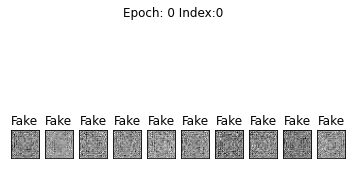

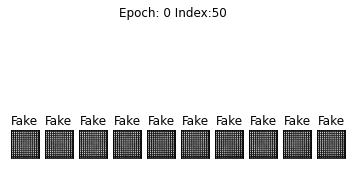

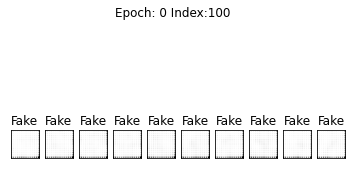

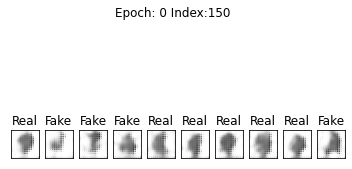

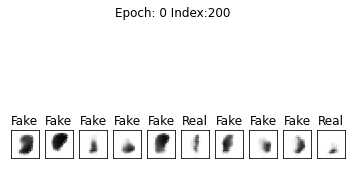

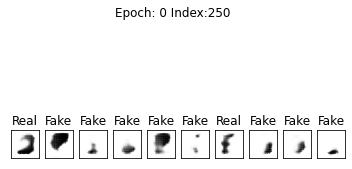

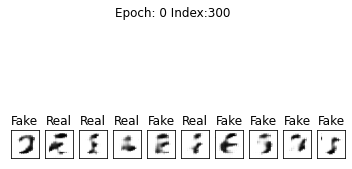

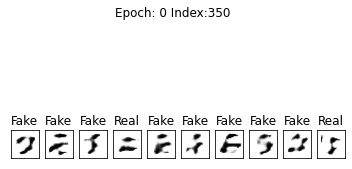

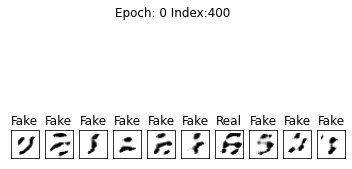

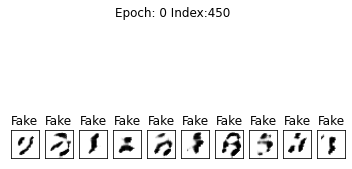

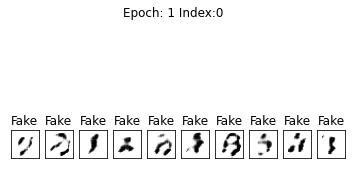

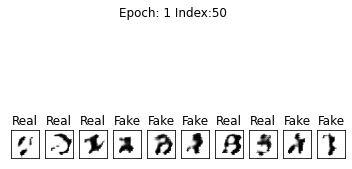

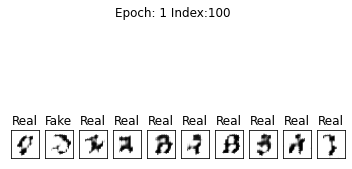

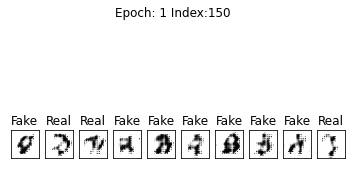

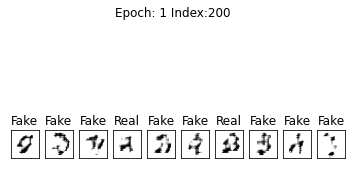

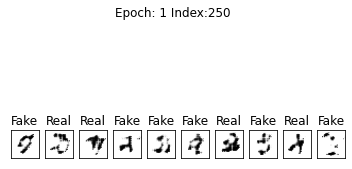

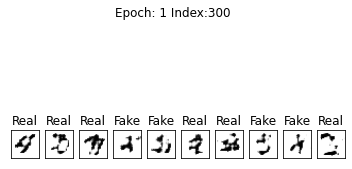

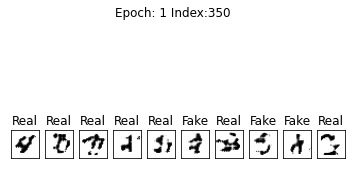

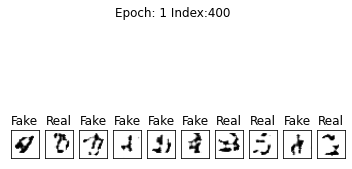

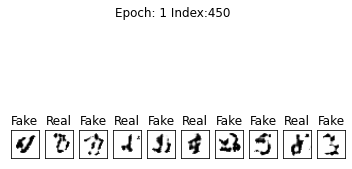

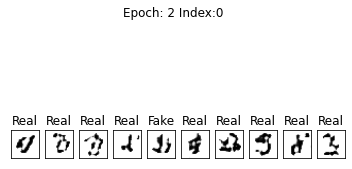

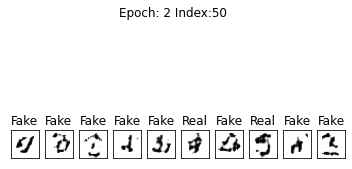

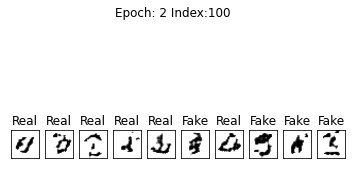

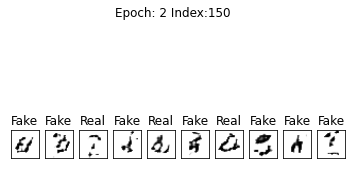

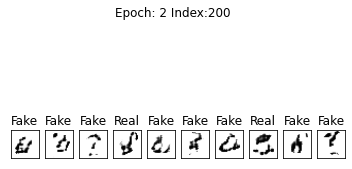

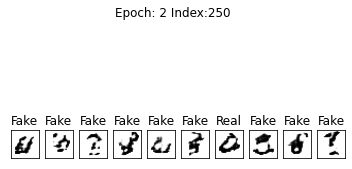

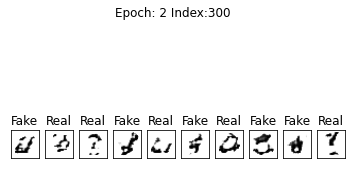

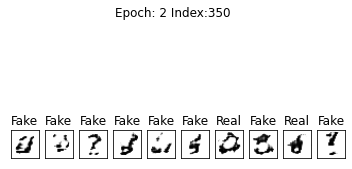

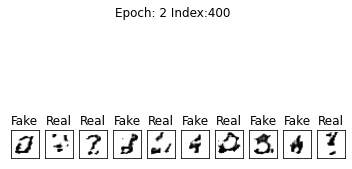

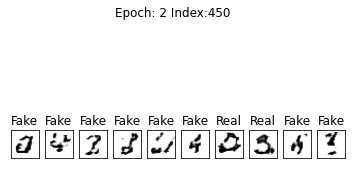

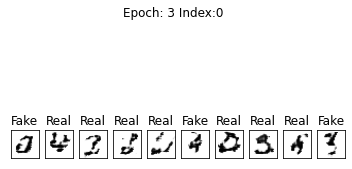

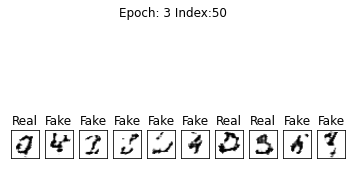

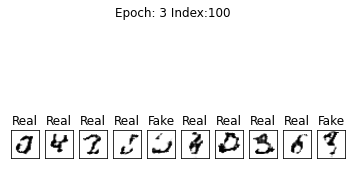

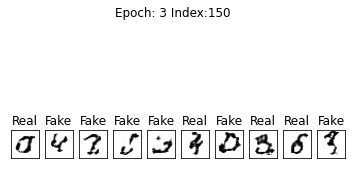

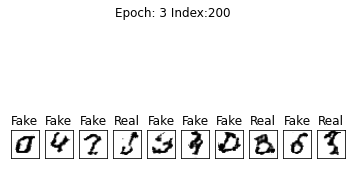

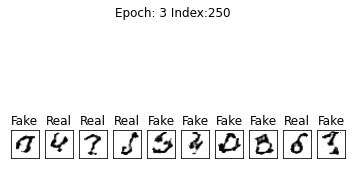

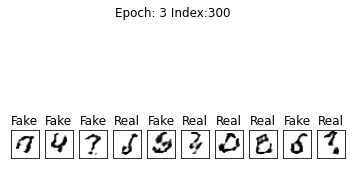

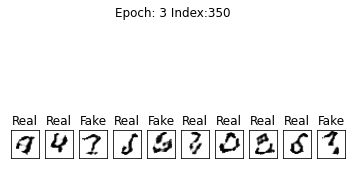

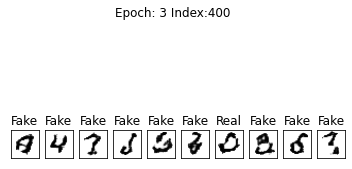

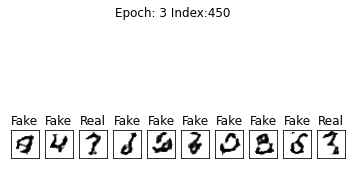

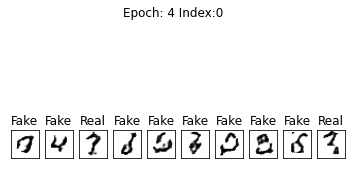

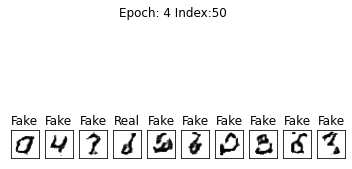

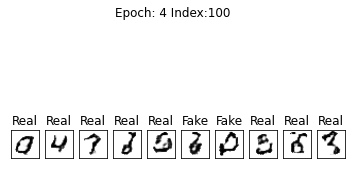

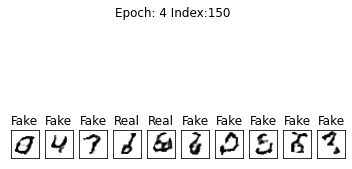

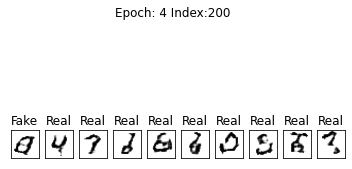

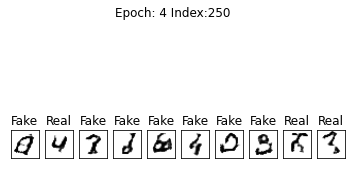

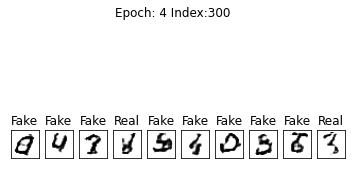

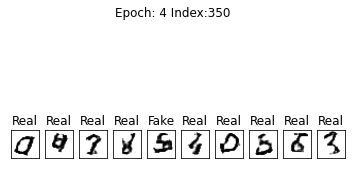

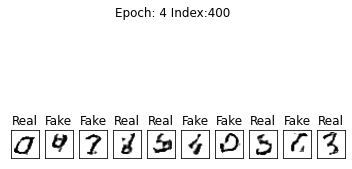

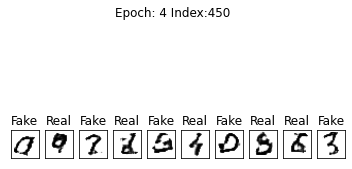

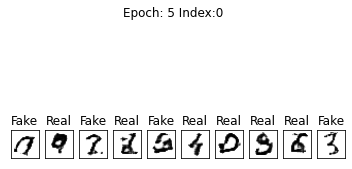

In [13]:
def main():
    set_seeds()

    epochs = 5
    lr = 0.0002
    beta1 = 0.5
    batch_size = 128
    sample = torch.randn(batch_size, z_dims)

    train_loader, test_loader = data_loader(batch_size)
    generator = create_generator_model()
    generator.apply(weights_init)

    discriminator = create_old_discriminator_model()
    discriminator.apply(weights_init)

    criterion = nn.BCELoss()

    generator_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
    discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

    train(sample, epochs, train_loader, generator_optimizer, discriminator_optimizer,
          generator, discriminator, criterion)

    view_images(epochs, 0, generator, discriminator, sample)
    plt.show()


main()

To get the best best results, I ran the model for a full 20 epochs, which took around 2 hours on a single CPU.

<img src="https://static.wixstatic.com/media/3466eb_a00e0e8b00c8418b981beb7e93331455~mv2.png/v1/fill/w_514,h_59,al_c,q_85/MNIST%20DCGAN.webp" alt="Generated numbers"/>